In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [3]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
import os
from dotenv import load_dotenv
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI



In [5]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b")


In [6]:
llm.invoke("hello how are you?")

AIMessage(content="I'm doing well, thank you for asking!  How are you?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b48cd214-40ac-4b8e-9883-31acdbad844c-0', usage_metadata={'input_tokens': 6, 'output_tokens': 17, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})

In [7]:
ul= "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [8]:
# Load the data
WebBaseLoader(ul).load()

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [9]:
WebBaseLoader(ul).load()[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resul

In [10]:
WebBaseLoader(ul).load()[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [11]:
WebBaseLoader(ul).load()[0].metadata["description"]

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [12]:

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [13]:
docs = [WebBaseLoader(url).load() for url in urls]

In [14]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [15]:
docs_list=[item for sublist in docs for item in sublist] # Convert to single list
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [16]:
# Chunking
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [17]:
# Add to vectorDB
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)


In [18]:
retriever = vectorstore.as_retriever()

In [19]:
# Tools for vector retrieval
retriever_tool=create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

In [20]:
# Tavily tool setup for web search
web_search_tool = TavilySearchResults()


In [21]:
tools = [web_search_tool]

In [22]:
# Convert tool to node
retrieve=ToolNode([retriever_tool])

Certainly! Let's break down the code:

### **Code Breakdown:**

```python
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
```

This code defines a class `AgentState` that is a **`TypedDict`**, which is a special kind of dictionary with fixed keys and value types, used to provide better type safety and autocompletion in Python.

Here’s a breakdown of each part:

---

### **1. `AgentState(TypedDict)`**
- **`TypedDict`**: This is a special class provided by `typing` that allows you to define dictionaries where each key has a fixed type. The dictionary keys are usually predefined, and each key must have a specified type.

  - `AgentState` here is a subclass of `TypedDict`, meaning `AgentState` will represent a dictionary where the types of its values are enforced.

  - Example:
    ```python
    agent_state = AgentState(messages=["Message 1", "Message 2"])  # This would be valid.
    ```

---

### **2. `messages: Annotated[Sequence[BaseMessage], add_messages]`**
- **`messages`**: This is a key in the `AgentState` dictionary. It holds a sequence (like a list or tuple) of `BaseMessage` objects.
  
- **`Annotated[...]`**: `Annotated` is used to attach additional metadata or annotations to the type. It’s a way to add extra information to the type system without affecting the actual type. In this case, it provides metadata for the `messages` field. 

  - The **`Annotated`** wrapper allows you to define a type and also include additional information that might be used by tools like static analyzers or for other purposes like validation.

- **`Sequence[BaseMessage]`**: This indicates that `messages` should be a sequence (e.g., a list or tuple) of `BaseMessage` objects.

  - **`BaseMessage`** is likely a class that represents a message in the context of your program. It could have fields like `content`, `sender`, `timestamp`, etc.
  
- **`add_messages`**: This is a special annotation (or metadata) that likely refers to some function or constant that’s being added as additional context. The specific role of `add_messages` will depend on how it's defined elsewhere in the codebase.

  - **`add_messages`** could be a function, validator, or modifier that helps manage or process the messages in some way, but it's not directly modifying the type of `messages`. It's simply metadata for the type checker or other parts of the system.

  - For example, if `add_messages` were a function, it could be used in a custom decorator, validation system, or simply as an indication of how to handle messages.

---

### **Putting It All Together:**

- **`AgentState`** is a dictionary where one of the keys, `messages`, is specifically typed to be a **sequence of `BaseMessage`** objects. The sequence is annotated with **`add_messages`**, which provides additional metadata but doesn’t affect the type directly.
  
- **Example of `AgentState` usage:**

```python
from typing import TypedDict, Sequence
from typing_extensions import Annotated

class BaseMessage:
    def __init__(self, content: str):
        self.content = content

# Defining the `AgentState` TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], "add_messages"]

# Example usage
message1 = BaseMessage("Hello, world!")
message2 = BaseMessage("How are you?")
state = AgentState(messages=[message1, message2])

print(state)
```

In the above code:
- `AgentState` is a dictionary with a `messages` field that is a sequence of `BaseMessage` objects.
- `add_messages` is metadata associated with the `messages` field, which can help guide the usage or interpretation of the data.

---

### **Summary:**
- `AgentState` is a dictionary where the `messages` key holds a sequence of `BaseMessage` objects.
- `Annotated[Sequence[BaseMessage], add_messages]` means that `messages` is a sequence of `BaseMessage` objects with additional metadata (`add_messages`).
- The annotation `add_messages` provides extra context or metadata that doesn't alter the type directly but can be used for purposes like validation or other system-specific behavior.


In [26]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] # Sequence of messages

In [27]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [28]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'") # type of output i will get

In [29]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [30]:
# Output generator
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}


In [31]:
# Rewrite :- For transforming the query
# Query_Rewriter
# Define query rewriter
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [32]:
# Define the workflow
workflow = StateGraph(AgentState)
workflow.add_node("My_Ai_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite) 

workflow.add_edge(START,"My_Ai_Assistant")

workflow.add_conditional_edges("My_Ai_Assistant",
                            tools_condition,
                            {"tools": "Vector_Retriever",
                                END: END,})


workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter"
                            }
                            )


workflow.add_edge("Output_Generator", END)
workflow.add_edge("Query_Rewriter", "My_Ai_Assistant")

In [33]:
app=workflow.compile()

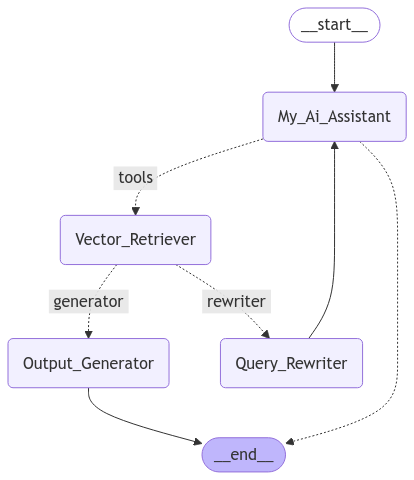

In [34]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [37]:
app.invoke({"messages":["what is Langchain?"]})

---CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='what is Langchain?', additional_kwargs={}, response_metadata={}, id='95ca1e42-b23d-4ae6-972f-08118b7fe6f4'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Langchain"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-0307ffc3-4f62-4eac-a50c-340beca95f79-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Langchain'}, 'id': 'c736c1bb-7965-463d-afe6-c5c12c721e07', 'type': 'tool_call'}], usage_metadata={

In [36]:
app.invoke({"messages":["what is a prompt engineering explain me in terms of agents and langchain?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='what is a prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='524c16a1-4e3b-4e1d-9aec-aa0a10d38bdd'),
  AIMessage(content="Unfortunately, the provided context only contains a `tavily_search_results_json` function.  It doesn't include any information about agents or Langchain.  Therefore, I cannot explain prompt engineering in terms of agents and Langchain.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-01a7dc34-f4

In [35]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='fdef39af-ef6d-43a0-90dd-d432105b8b31'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Autonomous Agent"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-31f2332b-9572-4c0a-9ee7-a2db0c919dfb-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Autonomous Agent'}, 'id': '540e6fdc-4b62-42f6-974d-64a6651fab1d', 'type': 'tool_ca

In [57]:
app.invoke({"messages":["what is capital of india?"]})


---CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='what is capital of india?', additional_kwargs={}, response_metadata={}, id='f8f33fcd-4dd8-4686-8f98-065bb1fe4639'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "capital of india"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-131729af-3745-48ba-98da-40ae2436fcf5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of india'}, 'id': 'ec28e98d-97d6-40db-a32e-533853043791', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 12, 'total_tokens': 92, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Error: tavily_search_results_json is not a valid tool, try one of [retrieve_blog_posts].', name='tavily_search_results_json', id='6190ebb5-cb80-44a3-9817-c17fadbeddda', tool_call_id='ec28e98d-97d6-40db-a32e-533853043791'